In [55]:
import pandas as pd
import plotly.express as px
from prophet import Prophet
from prophet.plot import plot_plotly
import json
import openpyxl

In [102]:
excel_file="CASE_SATIS_2021-22.xlsx" 
# Veri Yükleme
df_sales = pd.read_excel(excel_file, sheet_name="SATIŞ")
df_cross = pd.read_excel(excel_file, sheet_name="ÇAPRAZ SATIŞ")
df_demo = pd.read_excel(excel_file, sheet_name="ILCE DEMOGRAFI")


In [103]:
# Eğer integer ise:
df_cross["DEALER_CODE"] = df_cross["DEALER_CODE"] // 10

# 2. Tarih kolonlarını hizala
df_sales["AY"]   = df_sales["YEARMONTH"].astype(str)
df_cross["AY"]   = df_cross["AY"].astype(str)

# 3. Birleştirme: Sales + Cross
df = pd.merge(df_sales, df_cross.drop(columns=["AY"]), on="DEALER_CODE", how="left")

# 4. Birleştirme: ürüne demografi
df = pd.merge(df, df_demo, left_on="CITY", right_on="IL", how="left")

# 5. Hedef ve özellikler
#    - hedef: 'KANAL' (DIJITAL=1, FIZIKSEL=0)
#    - öznitelikler: URUNADET, URUNHACIM, ABONE_*, ÇAPRAZ_*, demografi sütunları


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# 2) Hedefi kodla
df["KANAL_BIN"] = (df["KANAL"]=="DIJITAL").astype(int)

# 3) Özellik listesini hazırla
#    Burada sayısal + kategorik ayrılsın
all_cols = df.columns.tolist()
exclude = ["DEALER_CODE","YEARMONTH","AY","KANAL","KANAL_BIN","CITY","ILCE"]
features = [c for c in all_cols if c not in exclude]

# otomatik olarak türlere bak:
numeric_features = [c for c in features if df[c].dtype in ["int64","float64"]]
categorical_features = [c for c in features if df[c].dtype == "object"]

# 4) Eğitim/test bölme
X = df[features]
y = df["KANAL_BIN"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5) Preprocessing + Model pipeline
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# 6) Eğit ve değerlendir
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# 7) 202301 verisiyle tahmin
new = pd.read_csv("sales_202301.csv", dtype={"DEALER_CODE":str})
new = pd.merge(new, cross.drop(columns=["AY"]), on="DEALER_CODE", how="left")
new = pd.merge(new, demo, left_on="CITY", right_on="ILCE", how="left")
X_new = new[features]

new["KANAL_PROB"] = pipeline.predict_proba(X_new)[:,1]
new["KANAL_PRED"] = pipeline.predict(X_new).map({1:"DIJITAL",0:"FIZIKSEL"})
print(new[["DEALER_CODE","KANAL_PROB","KANAL_PRED"]])

In [79]:

# sales: orijinal satış DataFrame
data = df_sales.copy()

# 1. Abonelik segmentlerinin toplam satış adedine katkı payı (%)
segments = data[['ABONE_YAS_0_3AY', 'ABONE_YAS_4_12AY', 'ABONE_YAS_1_3YAS', 'ABONE_YAS_3_YAS']].sum()
segment_pct = segments / segments.sum() * 100

# 2. Ortalama sepet büyüklüğü (ortalama gelir) hesaplama
total_adet = data['URUNADET'].sum()
total_hacim = data['URUNHACIM'].sum()
segment_revenue = (segments / total_adet) * total_hacim
avg_basket_size = segment_revenue / segments

# Sonuçları bir DataFrame'de gösterme
result = pd.DataFrame({
    'Segment Adet': segments,
    'Katkı (%)': segment_pct,
    'Tahmini Gelir (TL)': segment_revenue,
    'Ortalama Sepet (TL)': avg_basket_size
})
print(result)


                  Segment Adet  Katkı (%)  Tahmini Gelir (TL)  \
ABONE_YAS_0_3AY        7164883  11.569364        5.146359e+08   
ABONE_YAS_4_12AY      10960415  17.698130        7.872597e+08   
ABONE_YAS_1_3YAS      18085887  29.203856        1.299065e+09   
ABONE_YAS_3_YAS       25718607  41.528651        1.847304e+09   

                  Ortalama Sepet (TL)  
ABONE_YAS_0_3AY             71.827541  
ABONE_YAS_4_12AY            71.827541  
ABONE_YAS_1_3YAS            71.827541  
ABONE_YAS_3_YAS             71.827541  


In [92]:
# 1. Birim fiyatı hesapla
data['unit_price'] = data['URUNHACIM'] / data['URUNADET']

# 2. Segmentler
segments = ['ABONE_YAS_0_3AY', 'ABONE_YAS_4_12AY', 'ABONE_YAS_1_3YAS', 'ABONE_YAS_3_YAS']

# 3. Segment bazlı ortalama sepet büyüklüğünü hesapla
avg_basket = {}
for seg in segments:
    avg_basket[seg] = (data['unit_price'] * data[seg]).sum() / data[seg].sum()

# 4. Sonuçları tabloya çevir
avg_basket_df = pd.DataFrame.from_dict(
    avg_basket, orient='index', columns=['Ortalama Sepet (TL)']
)
print(avg_basket_df)

                  Ortalama Sepet (TL)
ABONE_YAS_0_3AY             73.607762
ABONE_YAS_4_12AY            69.951180
ABONE_YAS_1_3YAS            72.364579
ABONE_YAS_3_YAS             71.944671


In [93]:
data

,DEALER_CODE,YEARMONTH,NATIONALITY,URUNADET,URUNHACIM,ABONE_YAS_0_3AY,ABONE_YAS_4_12AY,ABONE_YAS_1_3YAS,ABONE_YAS_3_YAS,ABONE,unit_price
0,1326961,2022-12-01,OTHER,21362,4272056.00,1089,1242,3311,4365,10007,199.983897
1,787961,2022-12-01,OTHER,1410,278368.00,121,91,235,245,692,197.424113
2,560975,2022-12-01,TURK,990,99139.90,70,63,102,192,427,100.141313
3,132961,2022-12-01,TURK,1450,155447.74,63,85,164,324,636,107.205338
4,797961,2022-12-01,OTHER,1274,185040.00,326,85,72,75,558,145.243328
...,...,...,...,...,...,...,...,...,...,...,...
43971,227902,2021-06-01,OTHER,32,2203.94,4,2,4,2,12,68.873125
43972,1192963,2022-06-01,OTHER,6,420.00,0,0,0,2,2,70.000000
43973,169902,2022-01-01,OTHER,6,468.00,2,0,0,1,3,78.000000
43974,1078962,2022-04-01,OTHER,36,2818.00,1,5,5,4,15,78.277778


In [91]:
total_hacim

11202895150.5

In [63]:

# 1. Veriyi yükle
# 2. Tarih sütununu datetime'a çevir
df_sales['YEARMONTH'] = pd.to_datetime(df_sales['YEARMONTH'].astype(str), format='%Y%m')
# 3. Aylık toplam satış adedi ve tutarı
monthly = df_sales.groupby('YEARMONTH')[['URUNADET','URUNHACIM']].sum().reset_index()
# 4. Uyruk bazlı performans
nationality = df_sales.groupby('NATIONALITY')[['URUNADET','URUNHACIM']].sum().sort_values('URUNHACIM', ascending=False)
# 5. Abonelik yaşı segmentleri
segments = df_sales[['ABONE_YAS_0_3AY','ABONE_YAS_4_12AY','ABONE_YAS_1_3YAS','ABONE_YAS_3_YAS']].sum().sort_values(ascending=False)
# 6. Şube bazlı toplam
branches = df_sales.groupby('DEALER_CODE')[['URUNADET','URUNHACIM']].sum()
branches = branches.sort_values('URUNHACIM', ascending=False)
# 7. Alt performanslı şubeleri seç (alt %10)
low_perf = branches[branches['URUNADET'] <= branches['URUNADET'].quantile(0.1)]


In [73]:
pct_changes = monthly['URUNADET'].pct_change()
avg_monthly_growth = pct_changes.mean() * 100

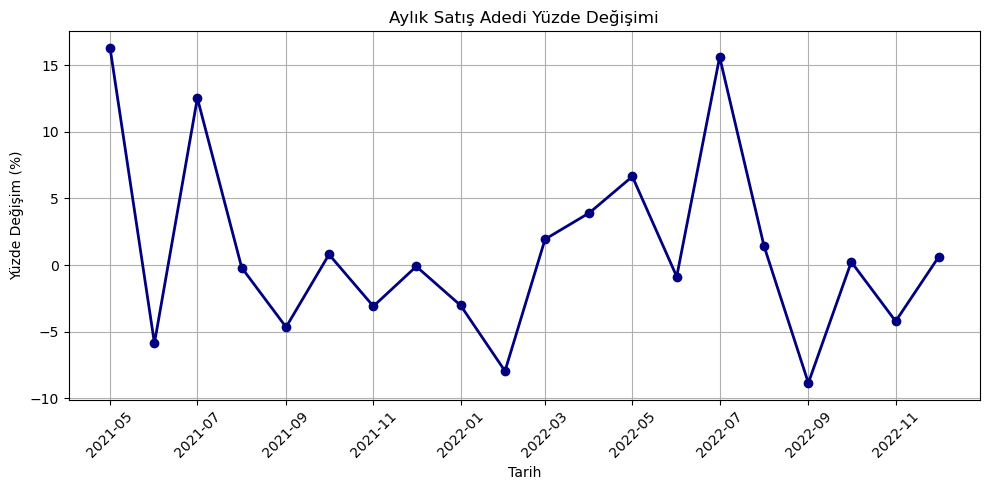

In [76]:
import matplotlib.pyplot as plt
# Yüzde değişim hesaplama
data = monthly.set_index('YEARMONTH')
pct_changes = data['URUNADET'].pct_change() * 100
# Grafiği çizme
plt.figure(figsize=(10,5))
plt.plot(pct_changes.index, pct_changes.values, color='#000080', marker='o', linewidth=2)
plt.title('Aylık Satış Adedi Yüzde Değişimi')
plt.xlabel('Tarih')
plt.ylabel('Yüzde Değişim (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
avg_monthly_growth

1.0570577195884838

In [66]:
monthly

,YEARMONTH,URUNADET,URUNHACIM
0,2021-04-01,6400206,3.193115e+08
1,2021-05-01,7442718,3.875868e+08
2,2021-06-01,7005876,3.605284e+08
3,2021-07-01,7883820,4.221287e+08
4,2021-08-01,7868022,4.272129e+08
5,2021-09-01,7501268,4.025345e+08
6,2021-10-01,7560872,4.090988e+08
7,2021-11-01,7326792,4.035603e+08
8,2021-12-01,7319104,4.101685e+08
9,2022-01-01,7097064,4.260307e+08


In [67]:
nationality

,URUNADET,URUNHACIM
NATIONALITY,,
TURK,122976786,8.619180e+09
OTHER,32992568,2.583715e+09


In [68]:
segments

ABONE_YAS_3_YAS     25718607
ABONE_YAS_1_3YAS    18085887
ABONE_YAS_4_12AY    10960415
ABONE_YAS_0_3AY      7164883
dtype: int64

In [72]:
branches

,URUNADET,URUNHACIM
DEALER_CODE,,
720983,106901900,7.874350e+09
1457962,471372,3.817228e+07
776961,422408,3.712786e+07
991961,347342,2.257812e+07
1326961,162142,2.206836e+07
...,...,...
1136961,632,3.132396e+04
957963,626,2.857766e+04
988962,458,2.473400e+04


In [70]:
low_perf

,URUNADET,URUNHACIM
DEALER_CODE,,
1330962,8202,769979.40
175963,7916,679797.28
245971,7544,678521.22
170969,8460,646290.50
175962,8750,632052.08
...,...,...
1136961,632,31323.96
957963,626,28577.66
988962,458,24734.00


In [45]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43976 entries, 0 to 43975
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DEALER_CODE       43976 non-null  int64  
 1   YEARMONTH         43976 non-null  int64  
 2   NATIONALITY       43976 non-null  object 
 3   URUNADET          43976 non-null  int64  
 4   URUNHACIM         43976 non-null  float64
 5   ABONE_YAS_0_3AY   43976 non-null  int64  
 6   ABONE_YAS_4_12AY  43976 non-null  int64  
 7   ABONE_YAS_1_3YAS  43976 non-null  int64  
 8   ABONE_YAS_3_YAS   43976 non-null  int64  
 9   ABONE             43976 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 3.4+ MB


In [4]:
df_cross

,AY,KANAL,BOLGE,CITY,DEALER_CODE,ÇAPRAZ ÜRÜN ADET,5GUNIPTAL,6-45GUNIPTAL
0,202104,DIJITAL,7,NaN,7209830,36764,72,1700
1,202104,FIZIKSEL,1,Uşak,3699680,92,8,6
2,202104,FIZIKSEL,1,Uşak,12229610,56,0,2
3,202104,FIZIKSEL,1,Uşak,12229620,34,0,4
4,202104,FIZIKSEL,1,Aydın,3909620,50,0,0
...,...,...,...,...,...,...,...,...
21946,202212,FIZIKSEL,6,Kahramanmaraş,7529630,414,20,132
21947,202212,FIZIKSEL,6,Kahramanmaraş,7529640,412,40,140
21948,202212,FIZIKSEL,6,Kahramanmaraş,7529680,80,16,28
21949,202212,FIZIKSEL,6,Kahramanmaraş,10819620,166,8,38


In [5]:
df_demo

,IL,ILCE,NUFUS,AB_SES_GRUBU_NUFUSU_(KISI),C_SES_GRUBU_NUFUSU_(KISI),DE_SES_GRUBU_NUFUSU_(KISI),ORTALAMA_HANE_GELIRI_(TL_/_AY),HABERLESME_HARCAMASI_(TL_/_AY),EGLENCE_VE_KULTUR_HARCAMASI_(TL_/_AY),EGITIM_HIZMETLERI_HARCAMASI_(TL_/_AY),UNIVERSITE_MEZUNU_(KISI),ORTALAMA_EGITIM_SURESI_(YIL),TOPLAM_CALISAN_(KISI),IS_GUCUNDE_OLMAYANLAR_(KISI),MAVI_YAKALI_CALISAN_(KISI),BEYAZ_YAKALI_CALISAN_ORAN_(_YUZDE_%),TOPLAM_EMEKLI_(KISI),TOPLAM_OGRENCI_(KISI),OTOMOBIL_SAYISI_(ADET),TOPLAM_TURIST_SAYISI_(KISI)
0,Adana,Seyhan,792536,135336.499999,437219.999999,250342.999999,9927.999999,333.0,256.0,194.0,97652.499999,8.499999,309549.999999,426764.999999,179600.999999,43.180000,113930.499999,212385.499999,140452.999999,71801.999999
1,Adana,Ceyhan,159955,22096.499999,84511.499999,50123.000000,6022.499999,186.5,129.0,78.0,17871.999999,8.499999,59665.000000,80032.999999,33033.500000,41.610000,29881.499999,41347.000000,16926.999999,626.999999
2,Adana,Feke,16072,396.000000,7309.499999,8491.999999,4041.999999,106.0,71.0,40.5,646.999999,7.500000,4851.999999,9049.999999,4829.499999,27.090000,4098.999999,2776.499999,1646.000000,626.999999
3,Adana,Karaisalı,21967,396.000000,12006.499999,8491.999999,5186.499999,167.5,119.5,66.5,1748.000000,7.500000,7756.999999,12305.999999,4829.499999,29.299999,5633.999999,4693.999999,2894.999999,626.999999
4,Adana,Karataş,23321,396.000000,12006.499999,11440.999999,4041.999999,106.0,71.0,40.5,1748.000000,7.500000,7756.999999,12305.999999,6496.499999,32.680000,4098.999999,4693.999999,1646.000000,2573.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,Düzce,Yığılca,14348,396.000000,7309.499999,5965.999999,4639.499999,150.5,110.5,27.5,646.999999,6.500000,4851.999999,9049.999999,3190.999999,23.255000,4098.999999,2776.499999,1646.000000,626.999999
792,Düzce,Cumayeri,15060,1385.500000,7309.499999,3807.999999,5735.999999,219.0,150.0,40.5,1748.000000,8.499999,4851.999999,9049.999999,3190.999999,36.144999,2643.999999,2776.499999,1646.000000,626.999999
793,Düzce,Gölyaka,20506,1385.500000,12006.499999,5965.999999,5186.499999,196.0,129.0,34.0,1748.000000,7.500000,7756.999999,9049.999999,4829.499999,33.985000,4098.999999,4693.999999,2894.999999,626.999999
794,Düzce,Gümüşova,16347,1385.500000,12006.499999,5965.999999,5186.499999,167.5,129.0,27.5,1748.000000,8.499999,7756.999999,9049.999999,4829.499999,35.125000,2643.999999,2776.499999,1646.000000,626.999999


In [8]:
df_time = df_sales.groupby('YEARMONTH')[['URUNADET', 'URUNHACIM']].sum().reset_index()


In [9]:
df_time

,YEARMONTH,URUNADET,URUNHACIM
0,202104,6400206,3.193115e+08
1,202105,7442718,3.875868e+08
2,202106,7005876,3.605284e+08
3,202107,7883820,4.221287e+08
4,202108,7868022,4.272129e+08
5,202109,7501268,4.025345e+08
6,202110,7560872,4.090988e+08
7,202111,7326792,4.035603e+08
8,202112,7319104,4.101685e+08
9,202201,7097064,4.260307e+08


In [11]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43976 entries, 0 to 43975
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DEALER_CODE       43976 non-null  int64  
 1   YEARMONTH         43976 non-null  int64  
 2   NATIONALITY       43976 non-null  object 
 3   URUNADET          43976 non-null  int64  
 4   URUNHACIM         43976 non-null  float64
 5   ABONE_YAS_0_3AY   43976 non-null  int64  
 6   ABONE_YAS_4_12AY  43976 non-null  int64  
 7   ABONE_YAS_1_3YAS  43976 non-null  int64  
 8   ABONE_YAS_3_YAS   43976 non-null  int64  
 9   ABONE             43976 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 3.4+ MB


In [12]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21951 entries, 0 to 21950
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   AY                21951 non-null  int64 
 1   KANAL             21951 non-null  object
 2   BOLGE             21951 non-null  int64 
 3   CITY              21930 non-null  object
 4   DEALER_CODE       21951 non-null  int64 
 5   ÇAPRAZ ÜRÜN ADET  21951 non-null  int64 
 6   5GUNIPTAL         21951 non-null  int64 
 7   6-45GUNIPTAL      21951 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.3+ MB


In [13]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   IL                                     796 non-null    object 
 1   ILCE                                   796 non-null    object 
 2   NUFUS                                  796 non-null    int64  
 3   AB_SES_GRUBU_NUFUSU_(KISI)             796 non-null    float64
 4   C_SES_GRUBU_NUFUSU_(KISI)              796 non-null    float64
 5   DE_SES_GRUBU_NUFUSU_(KISI)             796 non-null    float64
 6   ORTALAMA_HANE_GELIRI_(TL_/_AY)         796 non-null    float64
 7   HABERLESME_HARCAMASI_(TL_/_AY)         796 non-null    float64
 8   EGLENCE_VE_KULTUR_HARCAMASI_(TL_/_AY)  796 non-null    float64
 9   EGITIM_HIZMETLERI_HARCAMASI_(TL_/_AY)  796 non-null    float64
 10  UNIVERSITE_MEZUNU_(KISI)               796 non-null    float64
 11  ORTALA

In [42]:
      # Dealer -> City ilişkilendirme
dealer_city = df_cross[['DEALER_CODE', 'CITY']].drop_duplicates()
dealer_city = dealer_city.dropna()
dealer_city['DEALER_CODE'] = dealer_city['DEALER_CODE'] // 10
df_sales_map = pd.merge(df_sales,dealer_city, on='DEALER_CODE', how='inner')
df_city_sales = df_sales_map.groupby('CITY')['URUNADET'].sum().reset_index()

In [44]:
df_city_sales

,CITY,URUNADET
0,Adana,713604
1,Adıyaman,229266
2,Afyon,589180
3,Amasya,167982
4,Antalya,2033702
...,...,...
64,Çorum,430344
65,İstanbul,12858060
66,İzmir,2374378
67,Şanlıurfa,1153772


In [33]:
df_sales

,DEALER_CODE,YEARMONTH,NATIONALITY,URUNADET,URUNHACIM,ABONE_YAS_0_3AY,ABONE_YAS_4_12AY,ABONE_YAS_1_3YAS,ABONE_YAS_3_YAS,ABONE
0,1326961,202212,OTHER,21362,4272056.00,1089,1242,3311,4365,10007
1,787961,202212,OTHER,1410,278368.00,121,91,235,245,692
2,560975,202212,TURK,990,99139.90,70,63,102,192,427
3,132961,202212,TURK,1450,155447.74,63,85,164,324,636
4,797961,202212,OTHER,1274,185040.00,326,85,72,75,558
...,...,...,...,...,...,...,...,...,...,...
43971,227902,202106,OTHER,32,2203.94,4,2,4,2,12
43972,1192963,202206,OTHER,6,420.00,0,0,0,2,2
43973,169902,202201,OTHER,6,468.00,2,0,0,1,3
43974,1078962,202204,OTHER,36,2818.00,1,5,5,4,15


In [30]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43976 entries, 0 to 43975
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DEALER_CODE       43976 non-null  int64  
 1   YEARMONTH         43976 non-null  int64  
 2   NATIONALITY       43976 non-null  object 
 3   URUNADET          43976 non-null  int64  
 4   URUNHACIM         43976 non-null  float64
 5   ABONE_YAS_0_3AY   43976 non-null  int64  
 6   ABONE_YAS_4_12AY  43976 non-null  int64  
 7   ABONE_YAS_1_3YAS  43976 non-null  int64  
 8   ABONE_YAS_3_YAS   43976 non-null  int64  
 9   ABONE             43976 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 3.4+ MB


In [31]:
dealer_city.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1211 entries, 1 to 21149
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DEALER_CODE  1211 non-null   int64 
 1   CITY         1211 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.4+ KB


In [36]:
df_sales_map

,DEALER_CODE,YEARMONTH,NATIONALITY,URUNADET,URUNHACIM,ABONE_YAS_0_3AY,ABONE_YAS_4_12AY,ABONE_YAS_1_3YAS,ABONE_YAS_3_YAS,ABONE,CITY
0,1326961,202212,OTHER,21362,4272056.00,1089,1242,3311,4365,10007,NaN
1,787961,202212,OTHER,1410,278368.00,121,91,235,245,692,NaN
2,560975,202212,TURK,990,99139.90,70,63,102,192,427,NaN
3,132961,202212,TURK,1450,155447.74,63,85,164,324,636,NaN
4,797961,202212,OTHER,1274,185040.00,326,85,72,75,558,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43971,227902,202106,OTHER,32,2203.94,4,2,4,2,12,NaN
43972,1192963,202206,OTHER,6,420.00,0,0,0,2,2,NaN
43973,169902,202201,OTHER,6,468.00,2,0,0,1,3,NaN
43974,1078962,202204,OTHER,36,2818.00,1,5,5,4,15,NaN
